# Homework Assignment

1. Work through the `intro_to_whole_brain_modelling.ipynb` notebook (did this in the practical session on day 2)

2. Included below are the cells from that notebook necessary to run the brain stimulation simulations at the end of that notebook

3. Your task: explore different variations of the brain stimulation, and write a summary of your investigation. You could investigate: 

    - Stimulating different brain regions (recommended)  
    - Changing the parameters of the neurophysiological model (advanced)  
    - Changing conduction delays in the network (advanced)  
    - Changing the network structure (advanced)
    
Some additional pointers on how to get started on these are given at the bottom of this notebook


Your submitted assignment should take the form of a copy of this notebook, with your new work added at the end. 

Write in text what you chose to investigate, add comments in-line on what you are changing, and write a summary of what you have observed. 

The best assignment submissions will be highlighted in the final course wrap-up day. 


---

## Setup

If you are running this notebook in Google Colab, you will need to install some packages. If you are running in a more standard python environment, you need to ensure that these packages are installed externally (typically with `pip install <package>` on the command line).  

In [4]:
# If running in google colab, uncomment the install commands and execute this cell:

# TVB scientific library
#!pip install tvb-library

# TVB datasets
#!pip install tvb-data

# Neuroimaging library; we are just using this for visualization
#!pip install nilearn

# Library for making funky movies
#!pip install moviepy

# Library for power spectrum analysis
#!pip install fooof


Now import the libraries that are needed for the tutorial:

In [5]:
# Suppress warnings; keeps things cleaner
import warnings
warnings.filterwarnings('ignore')


# Standard scientific python import commands
import os,sys,glob,numpy as np,pandas as pd,seaborn as sns
sns.set_style('white')

%matplotlib inline
from matplotlib import pyplot as plt


# Some more matplotlib viz things
from matplotlib.pyplot import subplot
from matplotlib import cm
from numpy import exp,sin,cos,pi,tan,tanh
from matplotlib.tri import Triangulation
from IPython.display import Image,display,clear_output
from moviepy.editor import ImageSequenceClip


# Some nilearn viz tools
from nilearn.plotting import plot_surf_roi,plot_surf_stat_map,plot_surf


# TVB stuff
from tvb.simulator.lab import (models,connectivity,coupling,integrators,noise,simulator,
                              surfaces,region_mapping,monitors,equations,patterns,plot_pattern)

# For power spectrum calculations
from scipy.signal import welch
from fooof import FOOOF



In [6]:
# This is a utility function that gives a syntactically minimal way of writing a = np.array([a])
# (which is needed for many TVB method calls defining scalar parameters etc.)
def __(num): return np.array([num])

Some custom surface visualization functions (slightly better alternatives to `nilearn` functions, which we will also use)

In [7]:
def plot_surface_mpl(vtx,tri,data=None,rm=None,reorient='tvb',view='superior',
                     shaded=False,ax=None,figsize=(6,4), title=None,
                     lthr=None,uthr=None, nz_thr = 1E-20,
                     shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': None, 'vmax': None}):
                        
  r"""Plot surfaces, surface patterns, and region patterns with matplotlib
    
  This is a general-use function for neuroimaging surface-based data, and 
  does not necessarily require construction of or interaction with tvb 
  datatypes. 

  See also:  plot_surface_mpl_mv



  Parameters
  ----------
  
  vtx           : N vertices x 3 array of surface vertex xyz coordinates 

  tri           : N faces x 3 array of surface faces

  data          : array of numbers to colour surface with. Can be either 
                  a pattern across surface vertices (N vertices x 1 array),
                  or a pattern across the surface's region mapping 
                  (N regions x 1 array), in which case the region mapping 
                  bust also be given as an argument. 
                  
  rm            : region mapping - N vertices x 1 array with (up to) N 
                  regions unique values; each element specifies which 
                  region the corresponding surface vertex is mapped to 

  reorient      : modify the vertex coordinate frame and/or orientation 
                  so that the same default rotations can subsequently be 
                  used for image views. The standard coordinate frame is 
                  xyz; i.e. first,second,third axis = left-right, 
                  front-back, and up-down, respectively. The standard 
                  starting orientation is axial view; i.e. looking down on
                  the brain in the x-y plane.
                  
                  Options: 

                    tvb (default)   : swaps the first 2 axes and applies a rotation
                                              
                    fs              : for the standard freesurfer (RAS) orientation; 
                                      e.g. fsaverage lh.orig. 
                                      No transformations needed for this; so is 
                                      gives same result as reorient=None

  view          : specify viewing angle. 
  
                  This can be done in one of two ways: by specifying a string 
                  corresponding to a standard viewing angle, or by providing 
                  a tuple or list of tuples detailing exact rotations to apply 
                  around each axis. 
                  
                  Standard view options are:
    
                  lh_lat / lh_med / rh_lat / rh_med / 
                  superior / inferior / posterior / anterior

                  (Note: if the surface contains both hemispheres, then medial 
                   surfaces will not be visible, so e.g. 'rh_med' will look the 
                   same as 'lh_lat')
                   
                  Arbitrary rotations can be specied by a tuple or a list of 
                  tuples, each with two elements, the first defining the axis 
                  to rotate around [0,1,2], the second specifying the angle in 
                  degrees. When a list is given the rotations are applied 
                  sequentially in the order given. 
                  
                  Example: rotations = [(0,45),(1,-45)] applies 45 degrees 
                  rotation around the first axis, followed by 45 degrees rotate 
                  around the second axis. 

  lthr/uthr     : lower/upper thresholds - set to zero any datapoints below / 
                  above these values
  
  nz_thr        : near-zero threshold - set to zero all datapoints with absolute 
                  values smaller than this number. Default is a very small 
                  number (1E-20), which unless your data has very small numbers, 
                  will only mask out actual zeros. 

  shade_kwargs  : dictionary specifiying shading options

                  Most relevant options (see matplotlib 'tripcolor' for full details):
                  
                    - 'shading'        (either 'gourand' or omit; 
                                        default is 'flat')
                    - 'edgecolors'     'k' = black is probably best
                    - 'linewidth'      0.1 works well; note that the visual 
                                       effect of this will depend on both the 
                                       surface density and the figure size 
                    - 'cmap'           colormap
                    - 'vmin'/'vmax'    scale colormap to these values
                    - 'alpha'          surface opacity
                  
  ax            : figure axis
  
  figsize       : figure size (ignore if ax provided)
  
  title         : text string to place above figure
  
  
  
                  
  Usage
  -----
       

  Basic freesurfer example:

  import nibabel as nib
  vtx,tri = nib.freesurfer.read_geometry('subjects/fsaverage/surf/lh.orig')
  plot_surface_mpl(vtx,tri,view='lh_lat',reorient='fs')



  Basic tvb example:
  
  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat,view='inferior',title='inferior')

  fig, ax = plt.subplots()
  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat, view=[(0,-90),(1,55)],ax=ax,
                   title='lh angle',shade_kwargs={'shading': 'gouraud', 'cmap': 'rainbow'})

   
  """
    
  # Copy things to make sure we don't modify things 
  # in the namespace inadvertently. 
    
  vtx,tri = vtx.copy(),tri.copy()
  if data is not None: data = data.copy()

  # 1. Set the viewing angle 
  
  if reorient == 'tvb':
    # The tvb default brain has coordinates in the order 
    # yxz for some reason. So first change that:   
    vtx = np.array([vtx[:,1],vtx[:,0],vtx[:,2]]).T.copy()
    
    # Also need to reflect in the x axis
    vtx[:,0]*=-1

  # (reorient == 'fs' is same as reorient=None; so not strictly needed
  #  but is included for clarity)
   


  # ...get rotations for standard view options
    
  if   view == 'lh_lat'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'lh_med'    : rots =  [(0,-90),(1,-90) ] 
  elif view == 'rh_lat'    : rots =  [(0,-90),(1,-90) ]
  elif view == 'rh_med'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'superior'  : rots =   None
  elif view == 'inferior'  : rots =   (1,180)
  elif view == 'anterior'  : rots =   (0,-90)
  elif view == 'posterior' : rots =  [(0, -90),(1,180)]
  elif (type(view) == tuple) or (type(view) == list): rots = view 

  # (rh_lat is the default 'view' argument because no rotations are 
  #  for that one; so if no view is specified when the function is called, 
  #  the 'rh_lat' option is chose here and the surface is shown 'as is' 
                            
                            
  # ...apply rotations                          
     
  if rots is None: rotmat = np.eye(3)
  else:            rotmat = get_combined_rotation_matrix(rots)
  vtx = np.dot(vtx,rotmat)

                                    
      
  # 2. Sort out the data
                                    
                                    
  # ...if no data is given, plot a vector of 1s. 
  #    if using region data, create corresponding surface vector 
  if data is None: 
    data = np.ones(vtx.shape[0]) 
  elif data.shape[0] != vtx.shape[0]: 
    data = np.array([data[r] for r in rm])
    
  # ...apply thresholds
  if uthr: data *= (data < uthr)
  if lthr: data *= (data > lthr)
  data *= (np.abs(data) > nz_thr)

                                    
  # 3. Create the surface triangulation object 
  
  x,y,z = vtx.T
  tx,ty,tz = vtx[tri].mean(axis=1).T
  tr = Triangulation(x,y,tri[np.argsort(tz)])
                
  # 4. Make the figure 

  if ax is None: fig, ax = plt.subplots(figsize=figsize)  
  
  #if shade = 'gouraud': shade_opts['shade'] = 
  tc = ax.tripcolor(tr, np.squeeze(data), **shade_kwargs)
                        
  ax.set_aspect('equal')
  ax.axis('off')
    
  if title is not None: ax.set_title(title)






def plot_surface_mpl_mv(vtx=None,tri=None,data=None,rm=None,hemi=None,   # Option 1
                        vtx_lh=None,tri_lh=None,data_lh=None,rm_lh=None, # Option 2
                        vtx_rh=None,tri_rh=None,data_rh=None,rm_rh=None,
                        title=None,**kwargs):

  r"""Convenience wrapper on plot_surface_mpl for multiple views 
   
  This function calls plot_surface_mpl five times to give a complete 
  picture of a surface- or region-based spatial pattern. 

  As with plot_surface_mpl, this function is written so as to be 
  generally usable with neuroimaging surface-based data, and does not 
  require construction of of interaction with tvb datatype objects. 

  In order for the medial surfaces to be displayed properly, it is 
  necessary to separate the left and right hemispheres. This can be 
  done in one of two ways: 

  1. Provide single arrays for vertices, faces, data, and 
     region mappings, and addition provide arrays of indices for 
     each of these (vtx_inds,tr_inds,rm_inds) with 0/False 
     indicating left hemisphere vertices/faces/regions, and 1/True 
     indicating right hemisphere. 

     Note: this requires that 

  2. Provide separate vertices,faces,data,and region mappings for 
     each hemisphere (vtx_lh,tri_lh; vtx_rh,tri_rh,etc...)


 
  Parameters
  ----------

  (see also plot_surface_mpl parameters info for more details)

  (Option 1)

  vtx               :  surface vertices
 
  tri               : surface faces

  data              : spatial pattern to plot

  rm                : surface vertex to region mapping

  hemi              : hemisphere labels for each vertex
                      (1/True = right, 0/False = left) - 
      

  OR

  (Option 2)

  vtx_lh            : left hemisphere surface_vertices
  vtx_rh            : right ``      ``    ``     ``
  
  tri_lh            : left hemisphere surface faces 
  tri_rh            : right ``      ``    ``     ``

  data_lh          : left hemisphere surface_vertices
  data_rh          : right ``      ``    ``     ``

  rm_lh            : left hemisphere region_mapping
  rm_rh            : right ``      ``    ``     ``


  title            : title to show above middle plot
 
  kwargs           : additional tripcolor kwargs; see plot_surface_mpl

 

  Examples
  ----------

  # TVB default data

  # Plot one column of the region-based tract lengths 
  # connectivity matrix. The corresponding region is 
  # right auditory cortex ('rA1')

  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=rm,data=dat,
                      hemi=isrh_vtx,title=u'rA1 \ntract length')

  plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=rm,data=dat,
                    hemi=isrh_vtx,title=u'rA1 \ntract length',
                    shade_kwargs = {'shading': 'gouraud',
                                    'cmap': 'rainbow'}) 


  """
   

 
  if vtx is not None:                                    # Option 1
    tri_hemi = hemi[tri].any(axis=1)
    tri_lh,tri_rh = tri[tri_hemi==0],tri[tri_hemi==1]
  elif vtx_lh is not None:                               # Option 2
    vtx = np.vstack([vtx_lh,vtx_rh])
    tri = np.vstack([tri_lh,tri_rh+tri_lh.max()+1])

  if data_lh is not None:                                # Option 2
    data = np.hstack([data_lh,data_rh])
    
  if rm_lh is not None:                                  # Option 2 
    rm = np.hstack([rm_lh,rm_rh + rm_lh.max() + 1])
    
 

  # 2. Now do the plots for each view

  # (Note: for the single hemispheres we only need lh/rh arrays for the 
  #  faces (tri); the full vertices, region mapping, and data arrays
  #  can be given as arguments, they just won't be shown if they aren't 
  #  connected by the faces in tri )
  
  # LH lateral
  plot_surface_mpl(vtx,tri_lh,data=data,rm=rm,view='lh_lat',
                   ax=subplot(2,3,1),**kwargs)
    
  # LH medial
  plot_surface_mpl(vtx,tri_lh, data=data,rm=rm,view='lh_med',
                   ax=subplot(2,3,4),**kwargs)
    
  # RH lateral
  plot_surface_mpl(vtx,tri_rh, data=data,rm=rm,view='rh_lat',
                   ax=subplot(2,3,3),**kwargs)
    
  # RH medial
  plot_surface_mpl(vtx,tri_rh, data=data,rm=rm,view='rh_med',
                   ax=subplot(2,3,6),**kwargs)
    
  # Both superior
  plot_surface_mpl(vtx,tri, data=data,rm=rm,view='superior',
                   ax=subplot(1,3,2),title=title,**kwargs)
    
  plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0,
                      top=1.0, wspace=0, hspace=0) 




def get_rotation_matrix(rotation_axis, deg):
    
  '''Return rotation matrix in the x,y,or z plane'''
   
  
 
  # (note make deg minus to change from anticlockwise to clockwise rotation)
  th = -deg * (pi/180) # convert degrees to radians
    
  if rotation_axis == 0:
    return np.array( [[    1,         0,         0    ],
                      [    0,      cos(th),   -sin(th)],
                      [    0,      sin(th),    cos(th)]])
  elif rotation_axis ==1:
    return np.array( [[   cos(th),    0,        sin(th)],
                      [    0,         1,          0    ],
                      [  -sin(th),    0,        cos(th)]])
  elif rotation_axis ==2:
    return np.array([[   cos(th),  -sin(th),     0    ],
                     [    sin(th),   cos(th),     0   ],
                     [     0,         0,          1   ]])
    


def get_combined_rotation_matrix(rotations):
  '''Return a combined rotation matrix from a dictionary of rotations around 
     the x,y,or z axes'''
  rotmat = np.eye(3)
    
  if type(rotations) is tuple: rotations = [rotations] 
  for r in rotations:
    newrot = get_rotation_matrix(r[0],r[1])
    rotmat = np.dot(rotmat,newrot)
  return rotmat

In [20]:
conn = connectivity.Connectivity.from_file()
conn.configure()

surf = surfaces.CorticalSurface.from_file()#load_default=True)
vtx = surf.vertices
tri = surf.triangles

regmap = region_mapping.RegionMapping.from_file().array_data
isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
isrh_vtx = np.array([isrh_reg[r] for r in regmap])

reg_idxs = np.arange(0,conn.region_labels.shape[0])

WARNING  File 'hemispheres' not found in ZIP.


In [21]:
def jrmsim(simlength = 1000.,tavg_per=0.5,eeg_per=0.5,conn=None,sigma=None,
           jrm_params=None, cpl_params = None,int_dt=0.5,do_eeg=True,speed=3.,
           stim_eqn_params = dict(onset=1.5e3,T=500,tau=50), do_stim = False,stim_weighting=None):

    
    # Define the connectivity
    
    if conn is None:
        conn = connectivity.Connectivity.from_file()#(load_default=True)
        conn.speed = __(speed) 
        conn.configure()
        w_orig = conn.weights.copy()
        w_norm = (w_orig.T / w_orig.sum(axis=1) ).T
        w_norm[np.isnan(w_norm)] = 0

        
    # Define the model
        
    if jrm_params is None:
        jrm_params = dict(v0=np.array([6.]))
    else:
        jrm_params = {k: __(v) for k,v in jrm_params.items()}
    jrm = models.JansenRit(**jrm_params) 
    jrm.variables_of_interest = ('y0', 'y1', 'y2', 'y3', 'y4', 'y5')
    jrm.stvar = np.array([0,1,2,3,4,5])
    
    # Set the noise
    
    if sigma is None:
        phi_n_scaling = (jrm.a * jrm.A * (jrm.p_max-jrm.p_min) * 0.5 )**2 / 2.
        sigma         = np.zeros(6)
        sigma[3]      = phi_n_scaling *1e-5 #shrank noise by 1e-5
    
    
    # Define a stimulus
    
    if do_stim == False:
        stimulus = None
    else:
        stim_eqn_t = equations.PulseTrain()
        for k,v in stim_eqn_params.items(): stim_eqn_t.parameters[k] = v        
        stimulus = patterns.StimuliRegion(temporal=stim_eqn_t,
                                        connectivity=conn,
                                        weight=stim_weighting)
        
        
    # Define the coupling
    
    if cpl_params == None: 
        cpl_params = dict(a=__(0.00045))
    else: 
        cpl_params = {k: __(v) for k,v in cpl_params.items()}
    cpl = coupling.Linear(**cpl_params)

        
    # Set up the integration scheme
    
    solver = integrators.HeunStochastic(dt=int_dt,noise=noise.Additive(nsig=sigma)) #integrator dt is bottleneck
    
    
    # Define initial conditions
    
    init_conds = np.zeros([100,6,76,1]) # all zeros; doesn't really matter as we are using stochastic integration
    #                                     dimensions are specific to jansen-rit model (namely 6 state variables)        
        
        
    # Set up the monitors

    tavg_mon = monitors.TemporalAverage()
    tavg_mon.period = tavg_per
            
    if do_eeg:
        eeg_mon = monitors.EEG.from_file()
        eeg_mon.period = eeg_per
        mons=(tavg_mon,eeg_mon,)
    else:
        mons=(tavg_mon,)
        
        
     
    
    # Create the simulator object
    
    sim = simulator.Simulator(
        model=jrm,
        connectivity=conn,
        coupling=cpl,
        integrator=solver,
        initial_conditions=init_conds,
        simulation_length=simlength,
        monitors=mons,
        stimulus=stimulus
    ).configure()


    # Run the sim and put results into dataframes

    (tavg_time, tavg_data),(eeg_time,eeg_data) = sim.run()

    df_cPN = pd.DataFrame(np.squeeze(tavg_data[:,0,:,0]),index=tavg_time)
    df_cPN.index.names = ['t']
    df_cPN.columns.names = ['region']

    df_cEIN = pd.DataFrame(np.squeeze(tavg_data[:,1,:,0]),index=tavg_time)
    df_cEIN.index.names = ['t']
    df_cEIN.columns.names = ['region']

    df_cIIN = pd.DataFrame(np.squeeze(tavg_data[:,2,:,0]),index=tavg_time)
    df_cIIN.index.names = ['t']
    df_cIIN.columns.names = ['region']

    df_vPN =  pd.DataFrame(np.squeeze(tavg_data[:,3,:,0]),index=tavg_time)
    df_vPN.index.names = ['t']
    df_vPN.columns.names = ['region']

    
    df_eeg = pd.DataFrame(np.squeeze(eeg_data[:,0,:,0]),index=eeg_time)
    df_eeg.index.names = ['t']
    df_eeg.columns.names = ['chan']

    
    # Compute power spectrum

    freqs,ps_cPN = welch(df_cPN.values.T,fs=1000/tavg_per, noverlap = 0, nperseg=16000)
    df_ps_cPN = pd.DataFrame(ps_cPN.T,index=freqs)

    freqs,ps_cEIN = welch(df_cEIN.values.T,fs=1000/tavg_per, noverlap = 0, nperseg=16000)
    df_ps_cEIN = pd.DataFrame(ps_cEIN.T,index=freqs)

    freqs,ps_cIIN = welch(df_cIIN.values.T,fs=1000/tavg_per, noverlap = 0, nperseg=16000)
    df_ps_cIIN = pd.DataFrame(ps_cIIN.T,index=freqs)

    freqs,ps_vPN = welch(df_vPN.values.T,fs=1000/tavg_per, noverlap = 0, nperseg=16000)
    df_ps_vPN = pd.DataFrame(ps_vPN.T,index=freqs)

    freqs,ps_eeg = welch(df_eeg.values.T,fs=1000/eeg_per, noverlap = 0, nperseg=16000)
    df_ps_eeg = pd.DataFrame(ps_eeg.T,index=freqs)

    
    # Return a bunch of simulation outputs

    return (df_cPN,df_cEIN, df_cIIN, df_vPN, df_eeg,
            df_ps_cPN,df_ps_cEIN,df_ps_cIIN,df_ps_vPN, df_ps_eeg,tavg_data)

In [22]:
def get_fooof_params(df,freq_range = [0,50]):

    df_norm = df / df.sum(axis=0)

    powr = df_norm.loc[freq_range[0]:freq_range[1]].values.T
    freqs = df_norm.loc[freq_range[0]:freq_range[1]].index.values

    all_fooofers = []
    all_pps = []
    for p in powr[:,:]:
        thisfooofer = FOOOF(max_n_peaks=1)
        thisfooofer.fit(power_spectrum=p,freqs=freqs,freq_range=[0,50])
    
        all_fooofers.append(thisfooofer)
    
        pps = np.squeeze(thisfooofer.peak_params_)
    
        if pps.shape[0] == 0:
            pps = np.zeros(3)
        all_pps.append(pps)


    all_pps_arr = np.array(all_pps)

    df_all_pps = pd.DataFrame(all_pps_arr)

    
    
    clear_output()
    
    return df_all_pps

In [23]:
stim_node_label = 'lPFCCL'
stim_node_idx = np.nonzero(conn.region_labels == stim_node_label)[0]
stim_node_idx

array([55])

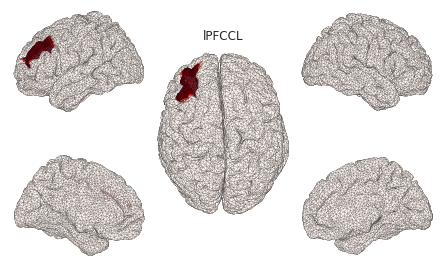

In [24]:
dat = np.zeros(conn.region_labels.shape[0])
dat[stim_node_idx] = 1.

plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=regmap,data=dat,
                    hemi=isrh_vtx,title='%s' %stim_node_label,
                    shade_kwargs = {'shading': 'flat',
                                    'cmap': 'Reds',
                                    'edgecolors': 'black', 
                                    'linewidth': 0.1,
                                    'vmin':0,'vmax':1})

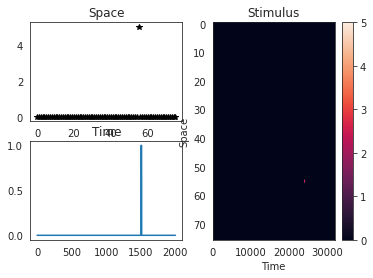

In [25]:
stim_eqn_params = dict(onset=1500,T=10000,tau=10)
stim_eqn_t = equations.PulseTrain()
for k,v in stim_eqn_params.items():
    stim_eqn_t.parameters[k] = v

# configure stimulus spatial pattern
stim_weighting = np.zeros(conn.region_labels.shape[0])
stim_weighting[stim_node_idx] = 5.

stimulus = patterns.StimuliRegion(
    temporal=stim_eqn_t,
    connectivity=conn,
    weight=stim_weighting)

#Configure space and time
stimulus.configure_space()
stimulus.configure_time(np.arange(0., 2e3, 2**-4))

#And take a look
plot_pattern(stimulus)

In [26]:
jrm_params = dict(v0=6.,a_1=1,a_2=0.8,a_3=0.2,a_4=0.25)

res = jrmsim(simlength=4000,jrm_params=jrm_params,int_dt=0.2,sigma=np.zeros(6),
             do_stim=True,stim_eqn_params=stim_eqn_params,stim_weighting=stim_weighting)

df_cPN,df_cEIN, df_cIIN, df_vPN,df_eeg,df_ps_cPN,df_ps_cEIN,df_ps_cIIN,df_ps_vPN,df_ps_eeg,tavg_data = res

df = df_cEIN

df_norm = df / df.loc[1400:].mean(axis=0)
df_norm.index = np.round(df_norm.index,1)

WARNING  File 'hemispheres' not found in ZIP.
   INFO  Projection configured gain shape (65, 76)


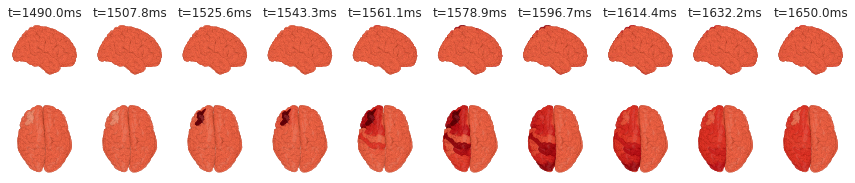

In [27]:
fig, ax = plt.subplots(ncols=10, nrows=2,figsize=(15,3))
cmap = cm.Reds
cmap.set_under(color='w')

kws = {'edgecolors': 'k', 'vmin': 0.9, 'cmap': cmap, 
       'vmax': 1.1, 'alpha': None, 'linewidth': 0.01}

ts = np.linspace(1490,1650,10)

for t_it,t in enumerate(ts):

    dat = df_norm.loc[t-5:t+5].mean(axis=0).values

    plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=regmap,ax=ax[0][t_it],
                   shade_kwargs=kws,
                   view='rh_lat')
    
    plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=regmap,ax=ax[1][t_it],
                   shade_kwargs=kws,
                   view='superior')
    
    
    ax[0][t_it].set_title('t=%1.1fms' %t)

In [28]:
%%time

cmap = cm.Reds
cmap.set_under(color='w')

kws = {'edgecolors': 'k', 'vmin': 0.9, 'cmap': cmap, 
       'vmax': 1.1, 'alpha': None, 'linewidth': 0.01}

#ts = np.linspace(400,750,50)
ts = np.linspace(1490,1650,30)

fs = []

os.system('rm temp_sim_stim_img__frame*')

for t_it,t in enumerate(ts):
   
    fig, ax = plt.subplots()#ncols=10, nrows=2,figsize=(15,3))

    dat = df_norm.loc[t-5:t+5].mean(axis=0).values
    
    plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=regmap,data=dat,
                    hemi=isrh_vtx,title='t=%1.0fms' %t,
                    shade_kwargs = kws)
        
    f = 'temp_sim_stim_img__frame_%03.0f.png' %t_it
    
    if os.path.isfile(f): os.remove(f)
    
    plt.savefig(f, bbox_inches='tight')
    plt.close()

    fs.append(f)

isc = ImageSequenceClip(sorted(fs),fps=10)
isc.to_gif('jrm_stim_sim.gif')

t:  23%|██▎       | 7/31 [00:00<00:00, 62.39it/s, now=None]

MoviePy - Building file jrm_stim_sim.gif with imageio.


CPU times: user 50 s, sys: 30.8 s, total: 1min 20s
Wall time: 49.9 s


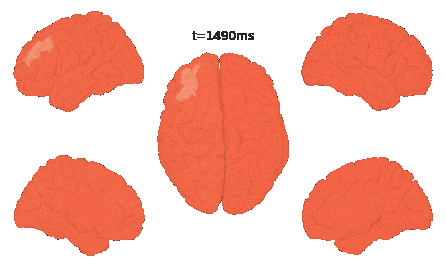

In [29]:
Image('jrm_stim_sim.gif')

In [30]:
# alternative, + need do this if on google colab
# isc.ipython_display()

<AxesSubplot:xlabel='t', ylabel='region'>

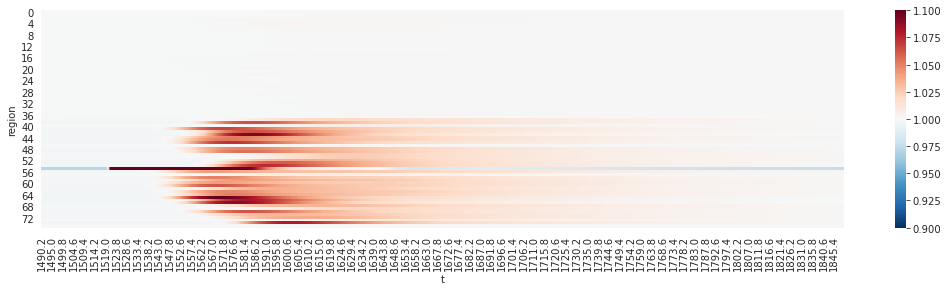

In [31]:
fig, ax = plt.subplots(figsize=(18,4))
sns.heatmap(df_norm.loc[1490:1850].T,cmap='RdBu_r',vmin=0.9,vmax=1.1, ax=ax)

---

---

---

## Some pointers

The brain region labels are given here

In [32]:
conn.region_labels

array(['rA1', 'rA2', 'rAMYG', 'rCCA', 'rCCP', 'rCCR', 'rCCS', 'rFEF',
       'rG', 'rHC', 'rIA', 'rIP', 'rM1', 'rPCI', 'rPCIP', 'rPCM', 'rPCS',
       'rPFCCL', 'rPFCDL', 'rPFCDM', 'rPFCM', 'rPFCORB', 'rPFCPOL',
       'rPFCVL', 'rPHC', 'rPMCDL', 'rPMCM', 'rPMCVL', 'rS1', 'rS2',
       'rTCC', 'rTCI', 'rTCPOL', 'rTCS', 'rTCV', 'rV1', 'rV2', 'rCC',
       'lA1', 'lA2', 'lAMYG', 'lCCA', 'lCCP', 'lCCR', 'lCCS', 'lFEF',
       'lG', 'lHC', 'lIA', 'lIP', 'lM1', 'lPCI', 'lPCIP', 'lPCM', 'lPCS',
       'lPFCCL', 'lPFCDL', 'lPFCDM', 'lPFCM', 'lPFCORB', 'lPFCPOL',
       'lPFCVL', 'lPHC', 'lPMCDL', 'lPMCM', 'lPMCVL', 'lS1', 'lS2',
       'lTCC', 'lTCI', 'lTCPOL', 'lTCS', 'lTCV', 'lV1', 'lV2', 'lCC'],
      dtype='<U128')

These abbreviations are from a parcellated called the 'Regional Map Parcellation'. Do some googling / informed guesswork to find out what brain regions these abbreviations correspond to. 

You can also visualize the location of the region as done above. 

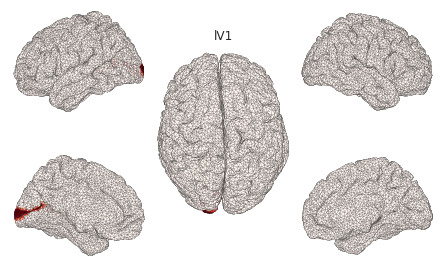

In [34]:
# Left visual cortex
stim_node_label = 'lV1'
stim_node_idx = np.nonzero(conn.region_labels == stim_node_label)[0]

dat = np.zeros(conn.region_labels.shape[0])
dat[stim_node_idx] = 1.

plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=regmap,data=dat,
                    hemi=isrh_vtx,title='%s' %stim_node_label,
                    shade_kwargs = {'shading': 'flat',
                                    'cmap': 'Reds',
                                    'edgecolors': 'black', 
                                    'linewidth': 0.1,
                                    'vmin':0,'vmax':1})

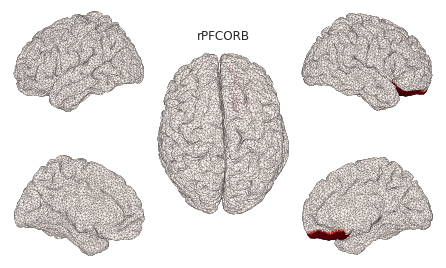

In [36]:
# Right orbitofrontal cortex
stim_node_label = 'rPFCORB'
stim_node_idx = np.nonzero(conn.region_labels == stim_node_label)[0]

dat = np.zeros(conn.region_labels.shape[0])
dat[stim_node_idx] = 1.

plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=regmap,data=dat,
                    hemi=isrh_vtx,title='%s' %stim_node_label,
                    shade_kwargs = {'shading': 'flat',
                                    'cmap': 'Reds',
                                    'edgecolors': 'black', 
                                    'linewidth': 0.1,
                                    'vmin':0,'vmax':1})

## Homework Assignment New Work

Name:

Date: 